In [1]:
# This notebook will run various models on the data to predict a more accurate value of the home.
# Feature engineering techniques will be employed.
# Many models will be built and compared to find the best model for the job.

In [150]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from scipy.stats import ks_2samp
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

pd.options.display.max_columns = None

In [151]:
# https://zacstewart.com/2014/08/05/pipelines-of-featureunions-of-pipelines.html
# https://stackoverflow.com/questions/24458645/label-encoding-across-multiple-columns-in-scikit-learn

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    # def fit(self,X,y=None):
    #     return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        # return self.fit(X,y).transform(X)
        return self.transform(X)


def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# Find best random state that minimizes the K-S distance:
# Use that min value for random state in the "actual" split below.
def minKS_tts(X, y, test_size):
    n_features = X.shape[1]
    n_tries = 100
    result = []
    for random_state in range(n_tries):
        X_train, X_test, _, _ = train_test_split(X, y, test_size=test_size, random_state=random_state)
        distances = list(map(lambda i : ks_2samp(X_train[:,i],X_test[:,i]).statistic,range(n_features)))
        result.append((random_state,max(distances)))
    result.sort(key = lambda x : x[1])
    return result[0][0]

# Matches 'series' column data statistical distribution to 'reference' column's statistical distribution.
# Uses ECDF
def match_ecdf(series, reference):
    sorted_series = np.sort(series, kind='mergesort')
    sorted_reference = np.sort(reference, kind='mergesort')
    ecdf_series = np.linspace(0, 1, len(series), endpoint=False)
    ecdf_reference = np.linspace(0, 1, len(reference), endpoint=False)
    matched_values = np.interp(ecdf_series, ecdf_reference, sorted_reference)
    matched_series = np.interp(sorted_series, sorted_series, matched_values)
    return matched_series

In [180]:
'''
Read in csv files.
'''
df_forSale = pd.read_csv('cleaned_forSale_data.csv', index_col=0)
df_recentlySold = pd.read_csv('cleaned_recentlySold_data.csv', index_col=0)

df_recentlySold['dateSold'] = pd.to_datetime(df_recentlySold['dateSoldString'])
df_recentlySold.drop('dateSoldString', axis=1, inplace=True)



modelColumns_recentlySold = ['daysOnZillow','zipcode','latitude','longitude','yearBuilt','bedrooms','bathrooms','livingAreaValue',
                             'resoFacts.associationFee','priceOutlier']

modelColumns_forSale = ['daysOnZillow','zipcode','latitude','longitude','yearBuilt','bedrooms','bathrooms','livingAreaValue',
                        'zestimate','resoFacts.associationFee','priceOutlier']

addtl = ['resoFacts.isSeniorCommunity','cityId','restimateHighPercent','restimateLowPercent','mortgageRates.thirtyYearFixedRate','mortgageRates.fifteenYearFixedRate',
         'resoFacts.garageSpaces','resoFacts.hasAdditionalParcels','resoFacts.hasAssociation',
         'resoFacts.hasGarage','resoFacts.hasPrivatePool','resoFacts.hasSpa','resoFacts.hasView','resoFacts.hasWaterfrontView',
         'resoFacts.taxAnnualAmount','schoolMaxRating','schoolMinDistance']

booleanFeatures = ['resoFacts.isSeniorCommunity','resoFacts.isSeniorCommunity','resoFacts.hasAdditionalParcels','resoFacts.hasAssociation',
                   'resoFacts.hasGarage','resoFacts.hasPrivatePool','resoFacts.hasSpa','resoFacts.hasView','resoFacts.hasWaterfrontView']

# List to keep track of rejected features... incase I want to add them back in.
rejectedFeatures = ['resoFacts.hasWaterfrontYN','rentZestimate','mortgageRates.arm5Rate','resoFacts.garageSpaces','listingSubType.isForeclosure','favoriteCount','resoFacts.hasAttachedProperty','lotAreaValue','taxAssessedValue','resoFacts.hasAttachedGarage']

modelColumns_recentlySold = modelColumns_recentlySold + addtl + ['price']
modelColumns_forSale = modelColumns_forSale + addtl

One of the most asked questions in data science/ML: Do you apply feature scaling before or after splitting your data?

Answer: Only one answer. ALWAYS AFTER SPLITTING DATA!! --  You need the test set to be a completely new, unseen data set. Feature scaling calculates means/std.dev's and so it must be done after the split to keep the two sets seperate. Key term: Information Leakage.

In [183]:
'''
Prep data for model training
'''
# Select only the columns needed for training/testing, apply OneHotEncoding, and convert to Numpy array for training.
modelData_recentlySold = df_recentlySold[modelColumns_recentlySold]
modelData_recentlySold = modelData_recentlySold.loc[modelData_recentlySold['priceOutlier']==0]
modelData_recentlySold.drop('priceOutlier', axis=1, inplace=True)
X_recentlySold = modelData_recentlySold.columns.difference(['price'], sort=False)
X_recentlySold = modelData_recentlySold[X_recentlySold]
X_recentlySold = np.array(MultiColumnLabelEncoder(columns=booleanFeatures)
                          .fit_transform(X_recentlySold))
y_recentlySold = np.array(modelData_recentlySold[['price']])
y_recentlySold = y_recentlySold.ravel()

# Data for KMeans clustering below. Needs to skip the scaling.
X_km_recentlySold = X_recentlySold.copy()
y_km_recentlySold = y_recentlySold.copy()

modelData_forSale = df_forSale[modelColumns_forSale]
modelData_forSale = modelData_forSale.loc[modelData_forSale['priceOutlier']==0]
modelData_forSale.drop('priceOutlier', axis=1, inplace=True)
zestimate = np.array(modelData_forSale['zestimate'])
modelData_forSale.drop('zestimate', axis=1, inplace=True)
X_forSale = np.array(MultiColumnLabelEncoder(columns=booleanFeatures)
                     .fit_transform(modelData_forSale))

# Data for KMeans clustering below. Needs to skip the scaling
X_km_forSale = X_forSale.copy()
y_km_forSale = zestimate.copy()

'''
Apply PCA??
'''

for i in range(X_forSale.shape[1]):
    '''??????Does this need to be applied to all columns or can I select which ones to match??????''' #<-- apply to all col except bools and numbers like zicodes and dates (non continuous)
    if i in [0,2,3,4,7,8,11,12,13,14,15,23]: #skip bools and categorical numbers
        X_recentlySold[:,i] = match_ecdf(X_recentlySold[:,i], X_forSale[:,i])

# for i in range(X_forSale.shape[1]):
#     # Assuming 'data1' and 'data2' are your datasets
#     statistic, p_value = ks_2samp(X_forSale[:, i], X_recentlySold[:, i])
#     if p_value < 0.05:
#         print(f"Distributions are significantly different: {statistic, p_value}")
#     else:
#         print(f"Distributions are not significantly different. {statistic, p_value}")


# # Split the data: recentlySold = 80% train/20% test. forSale = 100% test
# X_train, X_test, y_train, y_test = train_test_split(X_recentlySold, y_recentlySold, test_size=0.2, random_state=minKS_tts(X_recentlySold, y_recentlySold, 0.2))

# # Feature Scaling
# scaler = RobustScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)
# X_forSale = scaler.transform(X_forSale)

# Build, Train, and Test Clustering Model.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


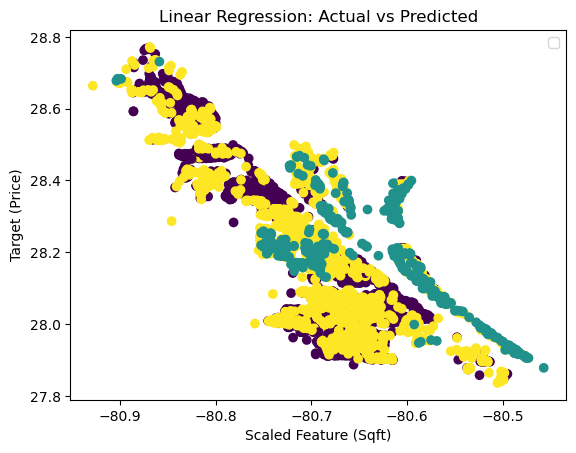

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


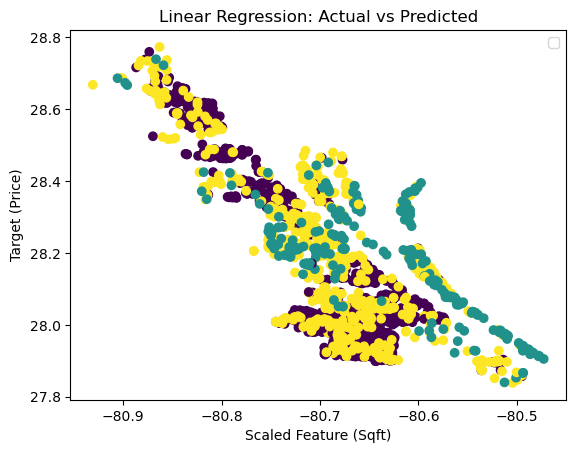

In [178]:
'''
KMeans to find best groups
'''
n_clusters = 3
km = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
y_km_recentlySold = y_km_recentlySold.reshape((y_km_recentlySold.shape[0],1))
km.fit(np.concatenate((X_km_recentlySold, y_km_recentlySold), axis=1))
recentlySoldLabels = km.labels_

y_km_forSale = y_km_forSale.reshape((y_km_forSale.shape[0],1))
forSaleLabels = km.predict(np.concatenate((X_km_forSale, y_km_forSale), axis=1))

# Plot recentlySold Clusters
plt.scatter(X_km_recentlySold[:,3], X_km_recentlySold[:,2], c=recentlySoldLabels)
plt.xlabel('Scaled Feature (Sqft)')
plt.ylabel('Target (Price)')
plt.title('Linear Regression: Actual vs Predicted')
plt.legend()
plt.show()

# Plot forSale Clusters
plt.scatter(X_km_forSale[:,3], X_km_forSale[:,2], c=forSaleLabels)
plt.xlabel('Scaled Feature (Sqft)')
plt.ylabel('Target (Price)')
plt.title('Linear Regression: Actual vs Predicted')
plt.legend()
plt.show()

# Build, Train, Test, and Validate Regression Models on recentlySold Dataset

In [9]:
'''
Creating variables for validation matrix at the end.
'''

MODEL = []
Training_R2 = []
MSE = []
RMSE = []
MAE = []
MAPE = []
MSLE = []

Testing_R2 = []
tMSE = []
tRMSE = []
tMAE = []
tMAPE = []
tMSLE = []


In [ ]:
'''
Build, train, test, and validate a LinearRegression() model
'''
MODEL.append('Linear Regression')


# Build, train, and test the model
parameters = {'fit_intercept':[True, False]}
lr = LinearRegression()
linReg = GridSearchCV(estimator=lr, param_grid=parameters, cv=10)
linReg.fit(X_train, y_train)
y_pred = linReg.predict(X_test)

for i, value in enumerate(y_pred):
    if value < 0:
        y_pred[i] = 0

# Visualize the results
plt.scatter(X_test[:,18], y_test, color='blue', label='Actual')
plt.scatter(X_test[:,18], y_pred, color='red', linewidth=2, label='Predicted')
plt.xlabel('Scaled Feature (Sqft)')
plt.ylabel('Target (Price)')
plt.title('Linear Regression: Actual vs Predicted')
plt.legend()
plt.show()

# Validate the model
print("Tuned Hyperparameters :(Best Parameters) ",linReg.best_params_)
print("Training R_Squared:",linReg.best_score_) # this value is the best score on TRAINING data!!
Training_R2.append(linReg.best_score_)
print('Training Metrics:')

# score_lr = linReg.score(X_train, y_train) # this value is the best score on TESTING data!!
# print("Testing R_Squared: ", score_lr)
score_lr = mean_squared_error(y_train, linReg.predict(X_train))
print("MSE: ", score_lr)
MSE.append(score_lr)
score_lr = np.sqrt(score_lr)
print("RMSE: ", score_lr)
RMSE.append(score_lr)
score_lr = mean_absolute_error(y_train, linReg.predict(X_train))
print("MAE: ", score_lr)
MAE.append(score_lr)
score_lr = mean_absolute_percentage_error(y_train, linReg.predict(X_train))
print("MAPE: ", score_lr)
MAPE.append(score_lr)
# score_lr = mean_squared_log_error(y_train, linReg.predict(X_train))
# print("MSLE: ", score_lr)
MSLE.append(None)
# score_lr = r2_score(y_train, linReg.predict(X_train))
# n = len(y_train)
# k = X_train.shape[1]
# score_lr = 1 - ((1-score_lr) * (n-1) / (n-k-1))
# print("Adjusted R2 Score: ", score_lr)
print('')

print('Test Metrics:')
score_lr = linReg.score(X_test, y_test) # this value is the best score on TESTING data!!
print("Testing R_Squared: ", score_lr)
Testing_R2.append(score_lr)
score_lr = mean_squared_error(y_test, y_pred)
print("MSE: ", score_lr)
tMSE.append(score_lr)
score_lr = np.sqrt(score_lr)
print("RMSE: ", score_lr)
tRMSE.append(score_lr)
score_lr = mean_absolute_error(y_test, y_pred)
print("MAE: ", score_lr)
tMAE.append(score_lr)
score_lr = mean_absolute_percentage_error(y_test, y_pred)
print("MAPE: ", score_lr)
tMAPE.append(score_lr)
score_lr = mean_squared_log_error(y_test, y_pred)
print("MSLE: ", score_lr)
tMSLE.append(score_lr)
score_lr = r2_score(y_test, y_pred)
n = len(y_test)
k = X_test.shape[1]
score_lr = 1 - ((1-score_lr) * (n-1) / (n-k-1))
print("Adjusted R2 Score: ", score_lr)
print('')

# Plot errors
residuals = y_test - y_pred
# Scatter plot of residuals
plt.scatter(X_test[:,18], residuals, color='blue', marker='o')
plt.xlabel('Scaled Feature (Sqft)')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

# Histogram of residuals
plt.hist(residuals, bins=10, color='blue', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Histogram')
plt.show()

del residuals

In [ ]:
test_min = []
test_max = []
sale_min = []
sale_max = []
for idx in range(0,X_test.shape[1]):
    test_min.append(X_train[:,idx].min())
    test_max.append(X_train[:,idx].max())
    sale_min.append(X_forSale[:,idx].min())
    sale_max.append(X_forSale[:,idx].max())

checkDict = {'X_Test Min':test_min, 'X_forSale Min':sale_min, 'X_Test Max':test_max, 'X_forSale Max':sale_max}

df_check = pd.DataFrame(checkDict)
df_check.head(25)

In [ ]:
'''
Look at correlation heatmap - Move to beginning of EDA
'''
plt.figure(figsize=(30, 15))
mask = np.triu(np.ones_like(modelData_recentlySold.corr(), dtype=np.bool_))
sns.heatmap(modelData_recentlySold.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
plt.show()

In [ ]:
'''
Build, train, test, and validate a RandomForest() model
'''
# Split the data: recentlySold = 80% train/20% test. forSale = 100% test
X_recentlySold = np.concatenate((X_recentlySold, recentlySoldLabels.reshape((recentlySoldLabels.shape[0],1))), axis=1)
y_recentlySold = np.concatenate((y_recentlySold.reshape((y_recentlySold.shape[0],1)), recentlySoldLabels.reshape((recentlySoldLabels.shape[0],1))), axis=1)
X_forSale_split = np.concatenate((X_forSale, forSaleLabels.reshape((forSaleLabels.shape[0],1))), axis=1)
zestimate_split = np.concatenate((zestimate.reshape((zestimate.shape[0],1)), forSaleLabels.reshape((forSaleLabels.shape[0],1))), axis=1)

test_size = 0.2

for kmn in range(n_clusters):

    X = X_recentlySold[X_recentlySold[:,-1]==kmn]
    y = y_recentlySold[y_recentlySold[:,-1]==kmn]
    y = y[:,0].copy()
    X_fS = X_forSale_split[X_forSale_split[:,-1]==kmn]
    zestimate = zestimate_split[zestimate_split[:,-1]==kmn]
    zestimate = zestimate[:,0].copy()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=minKS_tts(X, y, test_size))

    # Feature Scaling
    scaler = RobustScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_fS = scaler.transform(X_fS)

    
    # MODEL.append('Random Forest')

    # Build, train, and test the model
    parameters = {
        'n_estimators': [50, 100, 150],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 3, 5]
    }

    rf = RandomForestRegressor(random_state=42)
    randFor[kmn] = GridSearchCV(estimator=rf, param_grid=parameters, cv=10, scoring='r2', n_jobs=-1)
    randFor[kmn].fit(X_train, y_train)
    best_randFor[kmn] = randFor[kmn].best_estimator_
    y_pred = best_randFor[kmn].predict(X_test)

    # # Setting any price < 0 to be == 0
    # for i, value in enumerate(y_pred):
    #     if value < 0:
    #         y_pred[i] = 0

    # # Plot feature importance
    # importances = best_randFor.feature_importances_
    # std = np.std([tree.feature_importances_ for tree in best_randFor.estimators_], axis=0)
    # modelData_recentlySold.drop('price', axis=1, inplace=True)
    # forest_importances = pd.Series(importances, index=modelData_recentlySold.columns)
    # fig, ax = plt.subplots()
    # forest_importances.plot.bar(yerr=std, ax=ax)
    # ax.set_title("Feature importances using MDI")
    # ax.set_ylabel("Mean decrease in impurity")
    # fig.tight_layout()
    # plt.show()

    # # Visualize the results
    # plt.scatter(X_test[:,18], y_test, color='blue', label='Actual')
    # plt.scatter(X_test[:,18], y_pred, color='red', linewidth=2, label='Predicted')
    # plt.xlabel('Scaled Feature (Sqft)')
    # plt.ylabel('Target (Price)')
    # plt.title('Random Forest: Actual vs Predicted')
    # plt.legend()
    # plt.show()

    # Validate the model
    print("Tuned Hyperparameters: (Best Parameters) ",randFor[kmn].best_params_)
    print("Best Estimator: ",randFor[kmn].best_estimator_)
    print("Training R_Squared:",randFor[kmn].best_score_) # this value is the best score on TRAINING data!!
    print('Training Metrics:')

    score_lr = mean_squared_error(y_train, randFor[kmn].predict(X_train))
    print("MSE: ", score_lr)
    # MSE.append(score_lr)
    score_lr = np.sqrt(score_lr)
    print("RMSE: ", score_lr)
    # RMSE.append(score_lr)
    score_lr = mean_absolute_error(y_train, randFor[kmn].predict(X_train))
    print("MAE: ", score_lr)
    # MAE.append(score_lr)
    score_lr = mean_absolute_percentage_error(y_train, randFor[kmn].predict(X_train))
    print("MAPE: ", score_lr)
    print('')

    print('Test Metrics:')
    score_lr = randFor.score(X_test, y_test) # this value is the best score on TESTING data!!
    print("Testing R_Squared: ", score_lr)
    # Testing_R2.append(score_lr)
    score_lr = mean_squared_error(y_test, y_pred)
    print("MSE: ", score_lr)
    # tMSE.append(score_lr)
    score_lr = np.sqrt(score_lr)
    print("RMSE: ", score_lr)
    # tRMSE.append(score_lr)
    score_lr = mean_absolute_error(y_test, y_pred)
    print("MAE: ", score_lr)
    # tMAE.append(score_lr)
    score_lr = mean_absolute_percentage_error(y_test, y_pred)
    print("MAPE: ", score_lr)
    # tMAPE.append(score_lr)
    score_lr = mean_squared_log_error(y_test, y_pred)
    print("MSLE: ", score_lr)
    # tMSLE.append(score_lr)
    score_lr = r2_score(y_test, y_pred)
    n = len(y_test)
    k = X_test.shape[1]
    score_lr = 1 - ((1-score_lr) * (n-1) / (n-k-1))
    print("Adjusted R2 Score: ", score_lr)
    print('')

    # # Plot errors
    # residuals = np.transpose(y_test) - y_pred
    # # Scatter plot of residuals
    # plt.scatter(X_test[:,18], residuals, color='blue', marker='o')
    # plt.xlabel('Scaled Feature (Sqft)')
    # plt.ylabel('Residuals')
    # plt.title('Residuals Plot')
    # plt.show()

    # residuals = np.transpose(residuals)
    # # Histogram of residuals
    # plt.hist(residuals, bins=10, color='blue', alpha=0.7)
    # plt.xlabel('Residuals')
    # plt.ylabel('Frequency')
    # plt.title('Residuals Histogram')
    # plt.show()



    # Create predicted price
    forSale_pricePrediction[kmn] = best_randFor[kmn].predict(X_forSale[kmn])
    # forSale_pricePrediction = best_xgb_model.predict(X_forSale)
    # forSale_pricePrediction = linReg.predict(X_forSale)
    # forSale_pricePrediction = (best_randFor.predict(X_forSale) + best_xgb_model.predict(X_forSale)) / 2

    # Visualize the results
    plt.figure(figsize=(12, 10))
    plt.scatter(zestimate, forSale_pricePrediction, color='black', linewidth=2, label='Should Be Straight Line @ 45deg')
    plt.xlabel('Zestimate')
    plt.ylabel('Predicted Price')
    plt.title('Zestimate v. Predicted Price -- forSale Data')
    plt.xlim([0, 5e6])
    plt.ylim([0, 5e6])
    plt.legend()
    plt.show()

    # print(forSale_pricePrediction[0:4])
    # print(zestimate[0:4])

    y_pred = forSale_pricePrediction
    y_test = zestimate

    print('Test Metrics:')
    score_lr = mean_squared_error(y_test, y_pred)
    print("MSE: ", score_lr)
    score_lr = np.sqrt(score_lr)
    print("RMSE: ", score_lr)
    score_lr = mean_absolute_error(y_test, y_pred)
    print("MAE: ", score_lr)
    score_lr = mean_absolute_percentage_error(y_test, y_pred)
    print("MAPE: ", score_lr)
    score_lr = mean_squared_log_error(y_test, y_pred)
    print("MSLE: ", score_lr)
    score_lr = r2_score(y_test, y_pred)
    n = len(y_test)
    k = X_test.shape[1]
    score_lr = 1 - ((1-score_lr) * (n-1) / (n-k-1))
    print("Adjusted R2 Score: ", score_lr)
    print('')

    # Add predicted price to forSale dataframe - make sure index values match up....

    # Compute percent difference between zestimate and predicted price

    # Create final forSale csv for use in second go of EDA and final Plotly viz

    # Final EDA to include:
    # - Price value (% diff predicted v. Zestimate) vs zipcode



In [ ]:
# '''
# Build, train, test, and validate a XGBoost() model
# '''
# MODEL.append('XGBoost')

# # Split the data: recentlySold = 80% train/20% test. forSale = 100% test
# # X_temp = X_test
# # y_temp = y_test
# # X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=35)


# # Build, train, and test the model
# parameters = {
#     'n_estimators': [50, 100, 150],
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0],
#     'min_child_weight': [1, 5, 10],
#     'gamma': [0, 0.1, 0.2]
# }

# # best_parameters = {
# #     'n_estimators': [150],
# #     'max_depth': [3],
# #     'learning_rate': [0.2],
# #     'subsample': [1.0],
# #     'colsample_bytree': [1.0],
# #     'min_child_weight': [1],
# #     'gamma': [0]
# # }

# # xg = XGBRegressor(objective='reg:squarederror', random_state=42, early_stopping_rounds=10)
# xg = XGBRegressor(objective='reg:squarederror', random_state=42)

# boost = GridSearchCV(estimator=xg, param_grid=parameters, cv=10, scoring='r2', n_jobs=-1)

# # boost.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
# boost.fit(X_train, y_train)

# best_xgb_model = boost.best_estimator_

# y_pred_RF = y_pred
# y_pred = best_xgb_model.predict(X_test)

# for i, value in enumerate(y_pred):
#     if value < 0:
#         y_pred[i] = 0

# y_pred_XGB = y_pred

# # Visualize the results
# plt.scatter(X_test[:,18], y_test, color='blue', label='Actual')
# plt.scatter(X_test[:,18], y_pred, color='red', linewidth=2, label='Predicted')
# plt.xlabel('Scaled Feature (Sqft)')
# plt.ylabel('Target (Price)')
# plt.title('XGBoost: Actual vs Predicted')
# plt.legend()
# plt.show()

# # Validate the model
# print("Tuned Hyperparameters: (Best Parameters) ",boost.best_params_)
# print("Best Estimator: ",boost.best_estimator_)
# print("Training R_Squared:",boost.best_score_) # this value is the best score on TRAINING data!!
# Training_R2.append(boost.best_score_)
# print('Training Metrics:')

# # score_lr = linReg.score(X_train, y_train) # this value is the best score on TESTING data!!
# # print("Testing R_Squared: ", score_lr)
# score_lr = mean_squared_error(y_train, best_xgb_model.predict(X_train))
# print("MSE: ", score_lr)
# MSE.append(score_lr)
# score_lr = np.sqrt(score_lr)
# print("RMSE: ", score_lr)
# RMSE.append(score_lr)
# score_lr = mean_absolute_error(y_train, best_xgb_model.predict(X_train))
# print("MAE: ", score_lr)
# MAE.append(score_lr)
# score_lr = mean_absolute_percentage_error(y_train, best_xgb_model.predict(X_train))
# print("MAPE: ", score_lr)
# MAPE.append(score_lr)
# # score_lr = mean_squared_log_error(y_train, best_xgb_model.predict(X_train))
# # print("MSLE: ", score_lr)
# MSLE.append(None)
# # score_lr = r2_score(y_train, best_xgb_model.predict(X_train))
# # n = len(y_train)
# # k = X_train.shape[1]
# # score_lr = 1 - ((1-score_lr) * (n-1) / (n-k-1))
# # print("Adjusted R2 Score: ", score_lr)
# print('')

# print('Test Metrics:')
# score_lr = boost.score(X_test, y_test) # this value is the best score on TESTING data!!
# print("Testing R_Squared: ", score_lr)
# Testing_R2.append(score_lr)
# score_lr = mean_squared_error(y_test, y_pred)
# print("MSE: ", score_lr)
# tMSE.append(score_lr)
# score_lr = np.sqrt(score_lr)
# print("RMSE: ", score_lr)
# tRMSE.append(score_lr)
# score_lr = mean_absolute_error(y_test, y_pred)
# print("MAE: ", score_lr)
# tMAE.append(score_lr)
# score_lr = mean_absolute_percentage_error(y_test, y_pred)
# print("MAPE: ", score_lr)
# tMAPE.append(score_lr)
# score_lr = mean_squared_log_error(y_test, y_pred)
# print("MSLE: ", score_lr)
# tMSLE.append(score_lr)
# score_lr = r2_score(y_test, y_pred)
# n = len(y_test)
# k = X_test.shape[1]
# score_lr = 1 - ((1-score_lr) * (n-1) / (n-k-1))
# print("Adjusted R2 Score: ", score_lr)
# print('')

# # Plot errors
# residuals = np.transpose(y_test) - y_pred
# # Scatter plot of residuals
# plt.scatter(X_test[:,18], residuals, color='blue', marker='o')
# plt.xlabel('Scaled Feature (Sqft)')
# plt.ylabel('Residuals')
# plt.title('Residuals Plot')
# plt.show()

# residuals = np.transpose(residuals)
# # Histogram of residuals
# plt.hist(residuals, bins=10, color='blue', alpha=0.7)
# plt.xlabel('Residuals')
# plt.ylabel('Frequency')
# plt.title('Residuals Histogram')
# plt.show()

In [ ]:
# '''
# Create Ensemble Model from RandomForest and XGBoost
# '''
# MODEL.append('Ensemble')

# y_pred = (y_pred_RF + y_pred_XGB) / 2

# # Visualize the results
# plt.scatter(X_test[:,18], y_test, color='blue', label='Actual')
# plt.scatter(X_test[:,18], y_pred, color='red', linewidth=2, label='Predicted')
# plt.xlabel('Scaled Feature (Sqft)')
# plt.ylabel('Target (Price)')
# plt.title('Ensemble: Actual vs Predicted')
# plt.legend()
# plt.show()

# Training_R2.append(None)
# MSE.append(None)
# RMSE.append(None)
# MAE.append(None)
# MAPE.append(None)
# MSLE.append(None)


# print('Test Metrics:')
# score_lr = boost.score(X_test, y_test) # this value is the best score on TESTING data!!
# print("Testing R_Squared: ", score_lr)
# Testing_R2.append(score_lr)
# score_lr = mean_squared_error(y_test, y_pred)
# print("MSE: ", score_lr)
# tMSE.append(score_lr)
# score_lr = np.sqrt(score_lr)
# print("RMSE: ", score_lr)
# tRMSE.append(score_lr)
# score_lr = mean_absolute_error(y_test, y_pred)
# print("MAE: ", score_lr)
# tMAE.append(score_lr)
# score_lr = mean_absolute_percentage_error(y_test, y_pred)
# print("MAPE: ", score_lr)
# tMAPE.append(score_lr)
# score_lr = mean_squared_log_error(y_test, y_pred)
# print("MSLE: ", score_lr)
# tMSLE.append(score_lr)
# score_lr = r2_score(y_test, y_pred)
# n = len(y_test)
# k = X_test.shape[1]
# score_lr = 1 - ((1-score_lr) * (n-1) / (n-k-1))
# print("Adjusted R2 Score: ", score_lr)
# print('')

# # Plot errors
# residuals = np.transpose(y_test) - y_pred
# # Scatter plot of residuals
# plt.scatter(X_test[:,18], residuals, color='blue', marker='o')
# plt.xlabel('Scaled Feature (Sqft)')
# plt.ylabel('Residuals')
# plt.title('Residuals Plot')
# plt.show()

# residuals = np.transpose(residuals)
# # Histogram of residuals
# plt.hist(residuals, bins=10, color='blue', alpha=0.7)
# plt.xlabel('Residuals')
# plt.ylabel('Frequency')
# plt.title('Residuals Histogram')
# plt.show()

In [ ]:
# performanceDict = {'Model':MODEL, 'Training R2':Training_R2, 'Testing R2':Testing_R2, 'Training MSE':MSE, 'Testing MSE':tMSE, 'Training RMSE':RMSE, 
#                    'Testing RMSE':tRMSE, '*Training MAE*':MAE, '*Testing MAE*':tMAE, '*Training MAPE*':MAPE, '*Testing MAPE*':tMAPE, 'Training MSLE':MSLE, 
#                    'Testing MSLE':tMSLE}

# df_Performance = pd.DataFrame(performanceDict)
# df_Performance.head()

In [ ]:
# '''
# Execute best model on forSale Data

# XXXX NEEDS WORK!!! I DO NOT BELIEVE THESE RESULTS!! XXXX
# '''

# for kmn in range(n_clusters):

#     # Create predicted price
#     forSale_pricePrediction[kmn] = best_randFor[kmn].predict(X_forSale[kmn])
#     # forSale_pricePrediction = best_xgb_model.predict(X_forSale)
#     # forSale_pricePrediction = linReg.predict(X_forSale)
#     # forSale_pricePrediction = (best_randFor.predict(X_forSale) + best_xgb_model.predict(X_forSale)) / 2


#     # Visualize the results
#     plt.figure(figsize=(12, 10))
#     plt.scatter(zestimate[kmn], forSale_pricePrediction[kmn], color='black', linewidth=2, label='Should Be Straight Line @ 45deg')
#     plt.xlabel('Zestimate')
#     plt.ylabel('Predicted Price')
#     plt.title('Zestimate v. Predicted Price -- forSale Data')
#     plt.xlim([0, 5e6])
#     plt.ylim([0, 5e6])
#     plt.legend()
#     plt.show()

#     # print(forSale_pricePrediction[0:4])
#     # print(zestimate[0:4])

#     y_pred[kmn] = forSale_pricePrediction[kmn]
#     y_test[kmn] = zestimate[kmn]

#     print('Test Metrics:')
#     score_lr = mean_squared_error(y_test[kmn], y_pred[kmn])
#     print("MSE: ", score_lr)
#     score_lr = np.sqrt(score_lr)
#     print("RMSE: ", score_lr)
#     score_lr = mean_absolute_error(y_test[kmn], y_pred[kmn])
#     print("MAE: ", score_lr)
#     score_lr = mean_absolute_percentage_error(y_test[kmn], y_pred[kmn])
#     print("MAPE: ", score_lr)
#     score_lr = mean_squared_log_error(y_test[kmn], y_pred[kmn])
#     print("MSLE: ", score_lr)
#     score_lr = r2_score(y_test[kmn], y_pred[kmn])
#     n = len(y_test[kmn])
#     k = X_test[kmn].shape[1]
#     score_lr = 1 - ((1-score_lr) * (n-1) / (n-k-1))
#     print("Adjusted R2 Score: ", score_lr)
#     print('')

#     # Add predicted price to forSale dataframe - make sure index values match up....

#     # Compute percent difference between zestimate and predicted price

#     # Create final forSale csv for use in second go of EDA and final Plotly viz

#     # Final EDA to include:
#     # - Price value (% diff predicted v. Zestimate) vs zipcode

